# A search for electromagnetic counterparts to a candidate astrophysical neutrino event


Marcos Santander - Univ. of Alabama (jmsantander@ua.edu)

ISAPP 2022 - https://indico.ijclab.in2p3.fr/event/7633/

## Goals, requirements, and additional material

#### Goals for this exercise

* Understanding the basics of directional reconstrucion in neutrino telescopes.
* Searching for potential electromagnetic counterparts to the neutrino events.
* Checking for visibility of the potential counterparts to schedule additional target-of-opportunity observations.

#### Requirements

For this notebook to work, you need recent versions of the following libraries installed:
`matplotlib, numpy, astropy, urllib, pandas, scipy, scikit-spatial, astroquery`. If you're using `pip` you can install all of them by running this (**make sure that this doesn't break other compatibilities you may need**):

`pip install matplotlib numpy astropy urllib pandas scipy scikit-spatial astroquery`

#### Additional material

Some relevant papers:
* The detection of TXS 0506+056 in a flaring state during the follow-up of IC170922. [Paper](https://arxiv.org/abs/1807.08816)
* The IceCube realtime alert system [Paper](https://arxiv.org/abs/1612.06028)
* Recent updates to the realtime alert system [Paper](https://arxiv.org/abs/1908.04884)

In [33]:
##############################################
#%matplotlib notebook # If you can't run the notebook version comment this line out and uncomment the one below (inline) 
%matplotlib inline
##############################################

import numpy as np
import pylab as pl

from scipy.optimize import curve_fit

degree = np.pi / 180.

from skspatial.objects import Line
from skspatial.objects import Points
from skspatial.plotting import plot_3d

import pandas as pd

import urllib.request

## 1) IceCube detects an event

As part of its realtime alert system, IceCube broadcasts to the astronomical community the energy and position (with uncertainties) of newly-detected neutrino events of possible astrophysical origin. The alerts are sent out via the Gamma-ray Coordinates Network (GCN) and there are two basic types: muon track events with typical astrophysical probabilities of 50% and 30% (<a href="https://gcn.gsfc.nasa.gov/amon_icecube_gold_bronze_events.html">gold and bronze events</a>, respectively), and <a href="https://gcn.gsfc.nasa.gov/amon_icecube_cascade_events.html">cascade events</a>. You can <a href="https://gcn.gsfc.nasa.gov/invitation.html">subscribe</a> to receive these alerts from GCN. There are now more modern tools like AstroColibri (https://astro-colibri.com/) where you can get this information.

We will start from the very basic observation of a muon-track event in IceCube. The muon track is observed as a succession of light pulses observed by a volumetric array of PMTs within the IceCube geometry. 

In [34]:
# Positions of DOMs in IceCube (units are meters with respect to the center of the array)
urllib.request.urlretrieve('http://www.nevis.columbia.edu/~santander/dom_positions.csv', 'dom_positions.csv')
i3geo = pd.read_csv("dom_positions.csv")

# Light pulses 
urllib.request.urlretrieve('http://www.nevis.columbia.edu/~santander/pulse_times_positions.csv', 'pulse_times_positions.csv')
i3pulses = pd.read_csv("pulse_times_positions.csv")


There are 86 strings, each equipped with 60 DOMs. The center of the array along the *z* axis is at a depth of 1948 m below the ice surface at the South Pole.

In [8]:
i3geo

,x,y,z,string,dom
0,-256.140015,-521.080017,496.029999,1,1
1,-256.140015,-521.080017,479.010010,1,2
2,-256.140015,-521.080017,461.989990,1,3
3,-256.140015,-521.080017,444.970001,1,4
4,-256.140015,-521.080017,427.950012,1,5
...,...,...,...,...,...
5155,-10.970000,6.720000,-472.390015,86,56
5156,-10.970000,6.720000,-479.390015,86,57
5157,-10.970000,6.720000,-486.399994,86,58
5158,-10.970000,6.720000,-493.410004,86,59


Events in IceCube include time and charge (i.e. the amount of light) recorded by each DOM that participated in the event. We also list below the position of the participating DOM.

In [9]:
i3pulses

,charge,time,x,y,z,string_number,dom_number
0,0.525,10251.0,500.429993,-58.450001,-332.160004,30,50
1,0.625,11975.0,411.809998,13.000000,-179.100006,39,41
2,0.675,10658.0,411.809998,13.000000,-281.220001,39,47
3,0.825,9982.0,544.070007,55.889999,-246.130005,40,45
4,1.075,10004.0,544.070007,55.889999,-246.130005,40,45
...,...,...,...,...,...,...,...
61,0.425,13010.0,-101.059998,490.220001,161.070007,77,21
62,1.125,13051.0,-101.059998,490.220001,161.070007,77,21
63,1.425,13070.0,-101.059998,490.220001,161.070007,77,21
64,0.975,13088.0,-101.059998,490.220001,161.070007,77,21


Let's plot the pulses and the IceCube geometry. In this view the color represents the time of the pulse (red for early, blue for late) and the size indicates the amount of light seen by the DOM. The positions of other DOMS that didn't record a signal is shown in gray.

**Task 1**: rotate the view to get a better sense of the 3D distribution of the hit DOMs. How are they distributed? Is the muon going up or down through the detector? Can you make a guess regarding the zenith angle of the muon?

**Task 2**: could this be a muon from an air shower?

**Task 3**: rotate the view until you get a sideways view of IceCube, with the X axis shown horizontally and the -600 m on the *right* and +600 on the *left*. Do you notice anything unexpected about the distribution of hits in the detector? 

(-600.0, 600.0)

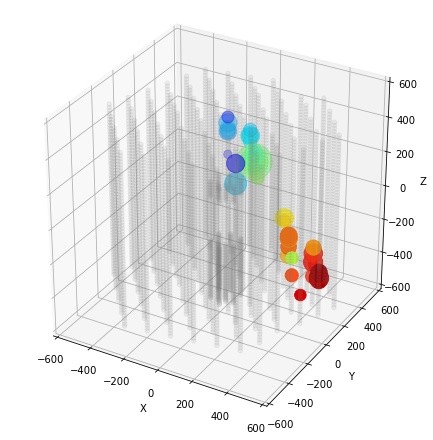

In [10]:
fig = pl.figure(figsize=(6,6), constrained_layout=True)
ax = pl.axes(projection='3d')

ax.scatter(i3pulses.loc[:,"x"], i3pulses.loc[:,"y"], i3pulses.loc[:,"z"], 
           c=i3pulses.loc[:,"time"], cmap=pl.get_cmap('jet_r'), s=i3pulses.loc[:,"charge"]*250)

ax.scatter(i3geo.loc[:,"x"], i3geo.loc[:,"y"], i3geo.loc[:,"z"], c='gray', alpha=0.1)

ax.set_box_aspect(( 1, 1, 1))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-600,600)
ax.set_ylim(-600,600)
ax.set_zlim(-600,600)

## 2) Event reconstruction

The incoming direction of the muon (and therefore the neutrino) are approximated using a simple line fit in this example. 

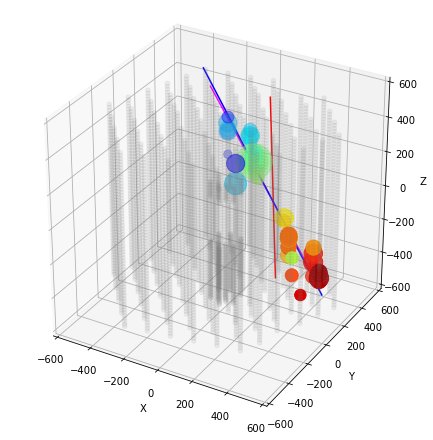

In [11]:
fig = pl.figure(figsize=(6,6), constrained_layout=True)
ax = pl.axes(projection='3d')

ax.scatter(i3pulses.loc[:,"x"], i3pulses.loc[:,"y"], i3pulses.loc[:,"z"], 
           c=i3pulses.loc[:,"time"], cmap=pl.get_cmap('jet_r'), s=i3pulses.loc[:,"charge"]*250)

ax.scatter(i3geo.loc[:,"x"], i3geo.loc[:,"y"], i3geo.loc[:,"z"], c='gray', alpha=0.1)

ax.set_box_aspect(( 1, 1, 1))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-600,600)
ax.set_ylim(-600,600)
ax.set_zlim(-600,600)


# Let's fit a line to the hit DOMs. We will assume an ultrarelativistic muon track moving (beta ~ 1) where 
# theta and phi represent the *direction* of the muon

def line(t, x0, y0, z0, t0, beta, theta, phi):
    c = 299792458.
    v0 = beta * c
    xv = v0 * np.cos(phi * degree) * np.sin(theta*degree) * (t-t0) + x0
    yv = v0 * np.sin(phi * degree) * np.sin(theta*degree) * (t-t0) + y0
    zv = v0 * np.cos(theta * degree) * (t-t0) + z0
    
    return np.concatenate([xv, yv, zv])

# We'll you the 3D coordinates and the times of the hits

x = i3pulses.loc[:,"x"]
y = i3pulses.loc[:,"y"]
z = i3pulses.loc[:,"z"]
t = i3pulses.loc[:,"time"] / 1e9

# This will be our first guess for the incoming direction
azi_start = 300
zen_start = 100

# This is the actual muon direction from MC
azi_mc = 327.56
zen_mc = 118.39


# As starting values for (x0, y0, z0, t0) we provide the means of those quantities
start_vals = [ np.mean(x), np.mean(y),  np.mean(z), 
              np.mean(t),  1,  180-zen_start, azi_start-180]


mc_vals = [ np.mean(x), np.mean(y),  np.mean(z), 
              np.mean(t),  1,  180-zen_mc, azi_mc-180]


xyz = np.concatenate([x, y, z])

# We use the scipy curve_fit() routine. popt is the array that contains 
# the best-fit values, and pcov the covariance matrix of the fit
popt, pcov = curve_fit(line, t, xyz, p0=start_vals)


# To plot it, let's create a uniform time interval 
t_fit = np.linspace(min(t), max(t), 100)

# Best-fit line
xyz_fit = line(t_fit, *popt).reshape(3, -1)

# First guess 
xyz_start = line(t_fit, *start_vals).reshape(3, -1)

# MC truth
xyz_mc = line(t_fit, *mc_vals).reshape(3, -1)

ax.plot(xyz_fit[0, :], xyz_fit[1, :], xyz_fit[2, :], color="magenta")
ax.plot(xyz_start[0, :], xyz_start[1, :], xyz_start[2, :], color="red")
ax.plot(xyz_mc[0, :], xyz_mc[1, :], xyz_mc[2, :], color="blue")


#parray = i3pulses[["x", "y", "z"]].values
#
#points = Points(parray)
#line_fit = Line.best_fit(points)
#line_fit.plot_3d(ax, t_1=-400, t_2=400, c='k')


**Question**: How would you improve on this simple line fit using the information provided and the physics involved?

Let's find the neutrino incoming direction in local coodinates (azi, zen).

In [12]:
azi = 180 + popt[6]
zen = 180 - popt[5]

azi_err = np.sqrt(pcov[6][6])
zen_err = np.sqrt(pcov[5][5])

print("Best-fit muon incoming direction:")
print("zen:", np.round(zen,2), "+/-", np.round(azi_err,2))
print("azi:", np.round(azi,2), "+/-", np.round(zen_err,2))


Best-fit muon incoming direction:
zen: 118.7 +/- 1.97
azi: 328.86 +/- 1.73


* The true neutrino direction was zen = 118.33 deg, azi = 327.60 deg

* The true muon direction is was zen = 118.39 deg, az = 327.56 deg

**The time of detection of the neutrino was MJD = 59390.8253**

**Task 4:** Using the <a href=https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/xTime/xTime.pl>NASA xtime</a> website, convert this time to a YYMMDD HH:MM date.

## 3) Sky position

We now have the position in local coordinates at the South Pole and the time of the event, we want to transform these into equatorial coordinates to search for a potential countepart.

In [13]:
%matplotlib inline
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time

mjdevent = 59390.8253

obstime = Time(mjdevent, format='mjd') 
print("Neutrino trigger time: ", obstime.iso)

# Position of the South Pole Station
sp_station = EarthLocation(lon=0 * u.deg, lat=-90 * u.deg, height=2835 * u.m)

pos = SkyCoord(alt = (90-zen) * u.deg, az = azi * u.deg, obstime = obstime, frame = 'altaz', location = sp_station)

# Let's find the coordinates of the neutrino 
print(pos.icrs)

Neutrino trigger time:  2021-06-25 19:48:25.920
<SkyCoord (ICRS): (ra, dec) in deg
    (179.86181574, 28.81787381)>


**Task 5:** Using the <a href="https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilpsc&Action=More+Options">NASA Browse</a> website, let's look for any potential counterparts in the Fermi 4FGL-DR3 catalog. Do the same for multiwavelength counterparts using <a href="https://simbad.u-strasbg.fr/simbad/">Simbad</a>.

## 4) Looking for gamma-ray counterparts in the Fermi-LAT 4FGL catalog

In [14]:
from astropy.io import fits

# Downloading 4FGL-DR3 
urllib.request.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/12yr_catalog/gll_psc_v28.fit', 'gll_psc_v28.fit')
fglcat = fits.open("gll_psc_v28.fit")[1].data

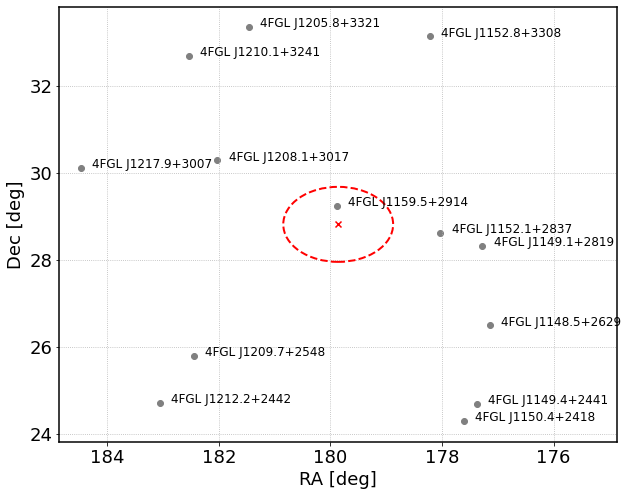

In [15]:
from matplotlib import patches

pl.rcParams['font.size'] = 18
pl.rcParams['axes.linewidth'] = 1.5 #set the value globally

# Let's find sources in a +/- 5 deg ROI around the best-fit neutrino position

fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)

window = 5 
sources_inroi = fglcat[(np.abs(fglcat['RAJ2000'] - pos.icrs.ra.deg) < window) & (np.abs(fglcat['DEJ2000'] - pos.icrs.dec.deg) < window)]

ax.scatter(sources_inroi['RAJ2000'], sources_inroi['DEJ2000'], color='gray')
ax.scatter([pos.icrs.ra.deg], [pos.icrs.dec.deg], color='red', marker='x')
e1 = patches.Ellipse((pos.icrs.ra.deg, pos.icrs.dec.deg), azi_err, zen_err, color='red', linestyle='--',
                     linewidth=2, fill=False, zorder=2)

for s in sources_inroi:
    ax.annotate(s['Source_Name'], (s['RAJ2000'] - 0.2, s['DEJ2000']), fontsize=12)

ax.add_patch(e1)


ax.set_xlim(pos.icrs.ra.deg + 5, pos.icrs.ra.deg - 5)
ax.set_ylim(pos.icrs.dec.deg - 5, pos.icrs.dec.deg + 5)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
pl.grid(linestyle=':')



**Task 6:** Look up the source contained in the uncertainty ellipse and find out more about it. Was it doing something interesting at the time of the alert? A good resource is the new <a href="https://fermi.gsfc.nasa.gov/ssc/data/access/lat/LightCurveRepository/">Fermi Light Curve Repository</a>. Search for the source and look at the flux at the alert time (you can select MJD for the time scale).

### 4.1) Plotting the Fermi LC

This is the LC retrieved from the Fermi LCR website.

In [16]:
urllib.request.urlretrieve('http://www.nevis.columbia.edu/~santander/4FGL_J1159.5+2914_daily_3_18_2022.csv', '4FGL_J1159.5+2914_daily_3_18_2022.csv')
fermilc = pd.read_csv("4FGL_J1159.5+2914_daily_3_18_2022.csv")

In [17]:
fermilc

,Date(UTC),Julian Date,MET,TS,Photon Flux [0.1-100 GeV](photons cm-2 s-1),Photon Flux Error(photons cm-2 s-1),Photon Index,Photon Index Error,Fit Tolerance,MINUIT Return Code,Analysis Log
0,Aug 06 2008,2454685,239716801,0.00,< 6.17e-8,-,-,-,1.000000e-08,0,bin1.log
1,Aug 09 2008,2454688,239976001,0.08,< 8.03e-8,-,-,-,1.000000e-08,0,bin2.log
2,Aug 12 2008,2454691,240235201,27.26,1.99e-7,6.00e-8,-2.1,-,1.000000e-08,0,bin3.log
3,Aug 15 2008,2454694,240494401,3.37,< 1.23e-7,-,-,-,1.000000e-08,0,bin4.log
4,Aug 18 2008,2454697,240753601,4.00,5.36e-8,3.54e-8,-2.1,-,1.000000e-08,0,bin5.log
...,...,...,...,...,...,...,...,...,...,...,...
1632,Mar 02 2022,2459642,667915201,214.29,4.68e-7,6.70e-8,-2.1,-,1.000000e-08,0,bin1653.log
1633,Mar 05 2022,2459645,668174401,232.79,5.10e-7,7.10e-8,-2.1,-,1.000000e-08,0,bin1654.log
1634,Mar 08 2022,2459648,668433601,106.09,3.97e-7,6.70e-8,-2.1,-,1.000000e-08,0,bin1655.log
1635,Mar 11 2022,2459651,668692801,144.60,4.87e-7,8.10e-8,-2.1,-,1.000000e-08,0,bin1656.log


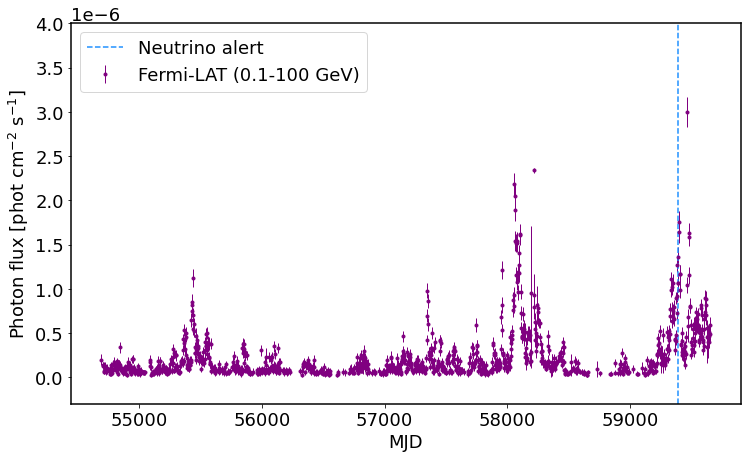

In [18]:
ts = fermilc.loc[:,"TS"].values

jd_vals = fermilc.iloc[:,1].values 
flux_vals = fermilc.iloc[:,4].values
fluxerr_vals = fermilc.iloc[:,5].values

# Get only those values with TS > 4
flux = [float(f) for f in flux_vals[ts > 4]]
flux_err = [float(f) for f in fluxerr_vals[ts > 4]]

mjd = [float(m) - 2400000.5 for m in jd_vals[ts > 4]]

fig = pl.figure(figsize=(12,7))
ax = fig.add_subplot(111)

ax.errorbar(mjd, flux, yerr=flux_err, linestyle="", linewidth=1, fmt='o', ms=3, color='purple', label='Fermi-LAT (0.1-100 GeV)')
ax.axvline(mjdevent, color='dodgerblue', linestyle='--', label='Neutrino alert')
ax.set_ylim(-3e-7, 4e-6)
ax.set_xlabel('MJD')
ax.set_ylabel(r'Photon flux [phot cm$^{-2}$ s$^{-1}$]')
ax.legend(loc=2)

Text(0, 0.5, 'Photon flux [phot cm$^{-2}$ s$^{-1}$]')

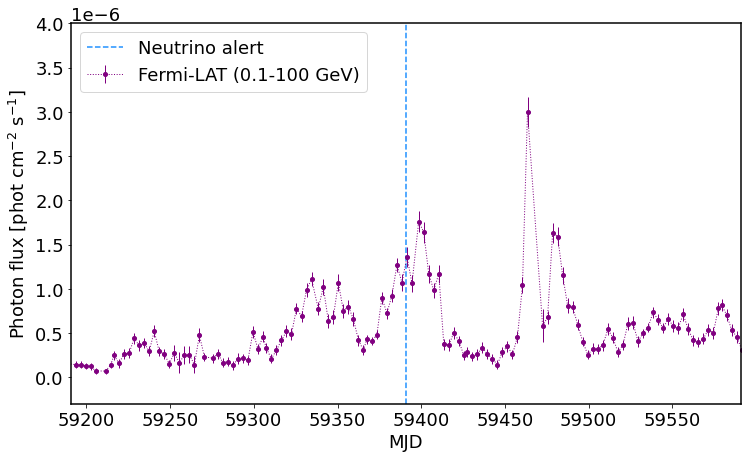

In [19]:
fig = pl.figure(figsize=(12,7))
ax = fig.add_subplot(111)

ax.errorbar(mjd, flux, yerr=flux_err, linestyle=":", linewidth=1, fmt='o', ms=4, color='purple', label='Fermi-LAT (0.1-100 GeV)')
ax.axvline(mjdevent, color='dodgerblue', linestyle='--', label='Neutrino alert')
ax.set_ylim(-3e-7, 4e-6)
ax.set_xlim(mjdevent-200, mjdevent+200)
ax.set_xlabel('MJD')
ax.legend(loc=2)
ax.set_ylabel(r'Photon flux [phot cm$^{-2}$ s$^{-1}$]')

**It looks like the source was in an active state!** It would be interesting to search for multiwavelength signatures of hadronic emission. There are two questions that you may ask yourself when identifying a potential counterpart:
* How likely is it for this association to be a chance coincidence?
* Can we search for EM signatures of hadronic emission that could be connected with the neutrino detection?

We will explore the first question next and the second one in Section 5.

If this were to happen in realtime, you can get Fermi-LAT data with a delay of ~12 hours, and it takes a couple of hours to run the analysis so if the source has been active for days it should be easy to pick it up but if there's a fast flare you would have to wait until the data is available in the <a href="https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi">Fermi-LAT Photon Server</a> to see it.

### 4.2) A quick estimate of the probability for a chance correlation

This source (4FGL J1159.5+2914, also known as Ton 599) was identified as a potential counterpart due to its close proximity to the best-fit neutrino position, within the error ellipse for the event. 

If the error ellipse were to be larger there would be larger probability of chance correlations, and in fact the angular resolution of neutrino telescopes typically drives the correlation probability, so we have to estimate how likely is this to happen. The probability $P_s$ for a single source to be contained in the error region is given by the ratio of the solid angle covered by the ellipse to the 4$\pi$ steradians in the sky.

$P_s = \frac{\Omega_{\nu}}{4 \pi}$

We will take the planar approximation to calculate the area of the elipse in degrees squared and then convert to steradians (note that this is not always good as you get closer to the poles or the ellipse is big).

$A = \pi \sigma_\phi \sigma_\theta$

In [20]:
Aellipse = np.pi * azi_err * zen_err
Aellipse 

10.671821752487737

Let's convert to steradians using $4\pi$ steradians = 41253 deg$^2$ <a href="https://en.wikipedia.org/wiki/Square_degree">[Ref.]</a>

In [21]:
Omega_nu = Aellipse / 41253.

In [22]:
Ps = Omega_nu / (4*np.pi)

import scipy.stats as st

# Returns a two-sided significance from a p-value
def pval2sigma(pval):
    return st.norm.ppf(1-(pval)/2)

# The p-value for a single coincidence given this uncertainty is then
print(Ps)
print("p-value:", Ps, " or ", np.round(pval2sigma(Ps),2), "sigma")

2.0586056574116264e-05
p-value: 2.0586056574116264e-05  or  4.26 sigma


This is pretty good! Right? But did we actually start from Ton 599 being the only source in the sky of interest? What if we had had another source in that place? 

We should correct for the fact that *any* source would have been interesting. For small p-values, the probability of having seen one coincidence given that we had $N_{src}$ sources is just:

$P_{fgl} = P_s * N_{src}$

In [23]:
Pfgl = Ps * len(fglcat)
print("p-value:", Pfgl, " or ", np.round(pval2sigma(Pfgl), 2), "sigma")

p-value: 0.1370825507270402  or  1.49 sigma


This is therefore not that shocking anymore. Now, there are very few sources in the sky that are as bright as Ton 599, but these are *a posteriori* considerations that are not always easy to quantify since we didn't start with an *a priori* source of interest or requirement regarding flux. We could calculate the probability for a source *equal or brighter than Ton 599* to be correlated.

In [24]:
# Flux of Ton 599 above 1 GeV 
ton599_flux = fglcat[fglcat['Source_name'] == '4FGL J1159.5+2914']['Flux1000'][0]

Nbright = len(fglcat[fglcat['Flux1000'] >= ton599_flux])

# How many sources in the 4FGL catalog have a flux higher or equal to Ton 599
print(Nbright)


95


In that case, the probability would be:

In [25]:
Pbright = Ps * Nbright
print("p-value:", Pbright, " or ", np.round(pval2sigma(Pbright), 2), "sigma")

p-value: 0.001955675374541045  or  3.1 sigma


Or about 0.2%, also 3.1 sigma. **<p style="color:red;">You have to be extremely careful in the interpretation of these a posteriori significance values.</p> It is very easy to cherry-pick particular parameters about your source that make it more important than it is**.

## 5) Planning and collecting follow-up observations

High-energy astrophysical sources such as AGN (like in the case of Ton 599) often display broadband emission spanning the entire electromagnetic spectrum, from radio to VHE gamma-rays. Signatures of hadronic emission in the spectral energy distribution (SED) of an AGN may appear in the form of VHE gamma-rays, or lower energy photons that can't be simply explained in the context of leptonic emission models. As these sources are also highly variable, it is critical that any information about the source is collected around the time of the potential neutrino emission. See for instance the observations collected during the 2017 campaign on TXS 0506+056 in the context of leptonic (left) and lepto-hadronic (right) models from <a href='https://arxiv.org/abs/1807.04275'>Ref</a>.

In this case the X-ray observations provided strong constraints on the potential hadronic emission associated with the neutrino detection.

<img src="https://www.nevis.columbia.edu/~santander/txs_leptohadronic.png" />

Fermi-LAT provides good coverage for the 0.1-100 GeV band, but for lower or higher energies you would need pointed observations. Your chances at convincing the Science Operations Center (for spacecrafts) or your Time Allocation Committee of giving you time on the telescope will likely depend on how promising the correlation looks, but still the source would have to be observable. 

We here concentrate on two bands: soft X-rays (0.3-10 keV) and VHE gamma-rays (> 0.1 TeV), in particular using the Neil Gehrels *Swift* observatory and VERITAS for VHE. Swift also has onboard and optical-UV telescope (UVOT) which provides photometry.

### 5.1) Checking for visibility for Swift

Swift, and other X-ray telescopes, have minimum angular distances defined to the moon (>23$^{\circ}$) and the sun (>47$^{\circ}$) to avoid stray light from damaging the telescope or the CCDs. The easiest way to check this is to use one of the online tools for visibility.

**Task 7:** Check the visibility of Ton 599 for Swift using the <a href="https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/viewing/viewing.pl">HEASARC Viewing website</a>.

### 5.2) Checking for visibility for VERITAS

We can use an online tool like <a href="https://www.arcsecond.io/iobserve">iObserve</a> that also has a standalone app available. Add Ton 599 as your target and enter the date of the event. To search for the VERITAS site, look for "Whipple" in the observatory box. Some things to consider: 

* Is the Moon present and what is its phase?
* What's the elevation of the source during the night? Typically observations with IACTs are not performed beyond 60 deg zenith, and the energy threshold increases with zenith angle. This is an issue for extragalactic sources with soft spectra.
* If there's Moon, would it be better to wait for a few nights until it goes away? Better to take data now?

#### Creating your own visibility plots

In [26]:
from astropy.coordinates import get_sun, get_moon
from astropy.coordinates import EarthLocation

In [27]:
sites = {
    'VERITAS' :  EarthLocation.of_site('Whipple'),
    'MAGIC' : EarthLocation.of_site('Roque de los Muchachos'),
    'HESS' : EarthLocation(lon=16.5019*u.deg, lat=-23.2713*u.deg, height=100*u.m),
    'HAWC' : EarthLocation(lon=-97*u.deg, lat=19*u.deg, height=4100*u.m)
}

In [28]:
class VisibilityPlot:
    def __init__(self, site, target, targetName="", tref = Time.now(), tevent=None, hstart=-4, hend=36):
        self.fig = pl.figure(figsize=(10,6))
        self.ax = self.fig.add_subplot(111)
        self.dt = np.linspace(hstart, hend, 300) * u.hour
        self.tref = tref
        self.tevent = tevent

        self.t0 = Time(np.floor(self.tref.mjd), format='mjd')
        self.times = self.t0 + self.dt

        altaz_frame = AltAz(obstime=self.times, location=site)
        sun_altaz = get_sun(self.times).transform_to(altaz_frame)
        moon_altaz = get_moon(self.times).transform_to(altaz_frame)

        #target = SkyCoord.from_name('M33')
        target_altaz = target.transform_to(altaz_frame)

        self.ax.plot(self.dt, sun_altaz.alt, color='orange', label='Sun', lw=3)
        self.ax.plot(self.dt, moon_altaz.alt, color="gray", ls='--', label='Moon', lw=3)

        self.ax.plot(self.dt, target_altaz.alt, label=targetName, color='red')

        self.ax.fill_between(self.dt.to('hr').value, 0, 90,
                 sun_altaz.alt < -0*u.deg, color='0.9', zorder=0)

        self.ax.fill_between(self.dt.to('hr').value, 0, 90,
                 sun_altaz.alt < -18*u.deg, color='0.75', zorder=0)

        self.ax.set_xlim(hstart, hend)
        self.ax.set_ylim(0,90)

        t1 = self.t0 + 1 * u.day

        self.ax.axvline(24, color='dodgerblue', lw=1, ls='--')
        self.ax.text(23.6,89, t1.iso.split(".")[0] + " UTC", rotation=90, \
                     color='dodgerblue', size=11, ha='center', va='top')

        self.ax.axvline(0, color='dodgerblue', lw=1, ls='--')
        self.ax.text(-0.4,89, self.t0.iso.split(".")[0] + " UTC", rotation=90, \
                     color='dodgerblue', size=11, ha='center', va='top')

        if tevent is not None:
            hevent = (self.tevent.mjd - self.t0.mjd) * 24.
            self.ax.axvline(hevent, color=[0.6,0.,0.], lw=1, ls='--')
            self.ax.text(hevent-0.4,89, "Event trigger: " + self.tevent.iso.split(".")[0] + " UTC", rotation=90, \
                     color=[0.6,0.,0.], size=11, ha='center', va='top', clip_on=True)

        self.ax.set_xticks(np.arange(hstart,hend,4))
        self.ax.set_xticklabels(np.arange(hstart,hend,4)%24)

        self.ax.set_xlabel('UTC Time')
        self.ax.set_ylabel('Altitude [$^{\circ}$]')

    def legend(self):
        self.ax.legend(loc='best')

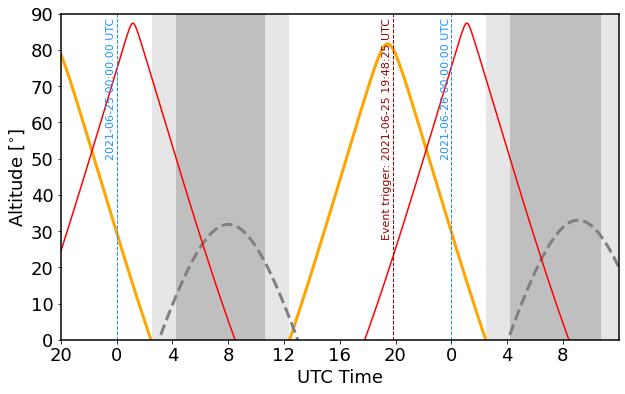

In [29]:
ton599_coord = SkyCoord.from_name("Ton 599")
VisibilityPlot(sites['VERITAS'], ton599_coord, "Ton 599", obstime, obstime)

Here the red line indicates the altitude of the source, orange is the sun, dash gray line is the moon, and the dark (light) bands are the astronomical (civil) twilights of the day. The brown line indicates the time of detection of the neutrino.

The moon is in the way, rising shortly after the start of the night, but you could still take some data (~1 hour) with the source above 40 deg altitude. The fact that the source is setting at the beginning of the night means that you won't have much more time until next year to take observations on it, so keep that in mind too.

## 6) Looking for other multiwavelength counterparts?

In [30]:
from astroquery.simbad import Simbad

In [31]:
result_table = Simbad.query_region(pos.icrs, radius=2 * u.deg)

In [32]:
print(result_table)

           MAIN_ID                  RA      ... SCRIPT_NUMBER_ID
                                 "h:m:s"    ...                 
----------------------------- ------------- ... ----------------
              SDSSCGB 28105.2  11 59 30.454 ...                1
              SDSSCGB 28105.1 11 59 29.9832 ...                1
       FIRST J115929.9+284543   11 59 29.99 ...                1
                SDSSCGB 28105    11 59 30.1 ...                1
              SDSSCGB 28105.3  11 59 29.427 ...                1
              SDSSCGB 28105.4  11 59 30.488 ...                1
                    CHSS  205 11 59 41.5431 ...                1
     SDSS J115924.03+284457.7  11 59 24.035 ...                1
                  BD+29  2242 11 59 13.6946 ...                1
     SDSS J115919.56+285415.3  11 59 19.560 ...                1
                          ...           ... ...              ...
     SDSS J120640.62+300259.6  12 06 40.627 ...                1
     SDSS J120226.96+3042

There are **many** potential counterparts! Not all of them are equally interesting, stars in the region of interest for instance are not VHE likely neutrino emitters. 

Still, if you have no likely counterparts Simbad is always a good place to get a broad sample of sources.

## 7) You're done!

Collect the observations, analyze, publish, maybe even earn Nobel Prize if you conclusively find the sources of HE neutrinos. Easy.